# Google Brain - Ventilator Pressure Prediction

##Simulate a ventilator connected to a sedated patient's lung



What do doctors do when a patient has trouble breathing? They use a ventilator to pump oxygen into a sedated patient's lungs via a tube in the windpipe. But mechanical ventilation is a clinician-intensive procedure, a limitation that was prominently on display during the early days of the COVID-19 pandemic. At the same time, developing new methods for controlling mechanical ventilators is prohibitively expensive, even before reaching clinical trials. High-quality simulators could reduce this barrier.

Current simulators are trained as an ensemble, where each model simulates a single lung setting. However, lungs and their attributes form a continuous space, so a parametric approach must be explored that would consider the differences in patient lungs.

Partnering with Princeton University, the team at Google Brain aims to grow the community around machine learning for mechanical ventilation control. They believe that neural networks and deep learning can better generalize across lungs with varying characteristics than the current industry standard of PID controllers.

In this competition, you’ll simulate a ventilator connected to a sedated patient's lung. The best submissions will take lung attributes compliance and resistance into account.

If successful, you'll help overcome the cost barrier of developing new methods for controlling mechanical ventilators. This will pave the way for algorithms that adapt to patients and reduce the burden on clinicians during these novel times and beyond. As a result, ventilator treatments may become more widely available to help patients breathe.




## Data Description

The ventilator data used in this competition was produced using a modified open-source ventilator connected to an artificial bellows test lung via a respiratory circuit. The diagram below illustrates the setup, with the two control inputs highlighted in green and the state variable (airway pressure) to predict in blue. The first control input is a continuous variable from 0 to 100 representing the percentage the inspiratory solenoid valve is open to let air into the lung (i.e., 0 is completely closed and no air is let in and 100 is completely open). The second control input is a binary variable representing whether the exploratory valve is open (1) or closed (0) to let air out.

In this competition, participants are given numerous time series of breaths and will learn to predict the airway pressure in the respiratory circuit during the breath, given the time series of control inputs.

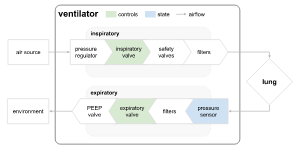


Each time series represents an approximately 3-second breath. The files are organized such that each row is a time step in a breath and gives the two control signals, the resulting airway pressure, and relevant attributes of the lung, described below.


## Files
> train.csv - the training set

> test.csv - the test set

> sample_submission.csv - a sample submission file in the correct format

## Columns
> id - globally-unique time step identifier across an entire file

> breath_id - globally-unique time step for breaths

> R - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.

> C - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.

> time_step - the actual time stamp.
u_in - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.

> u_out - the control input for the exploratory solenoid valve. Either 0 or 1.
pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O.

## Install Libraries

In [1]:
!pip install opendatasets scikeras -q

## Import Libraries

In [2]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

## Download The Dataset

In [7]:
od.download('https://www.kaggle.com/competitions/ventilator-pressure-prediction/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omjiverma
Your Kaggle Key: ··········


100%|██████████| 223M/223M [00:01<00:00, 128MB/s] 



Extracting archive ./ventilator-pressure-prediction/ventilator-pressure-prediction.zip to ./ventilator-pressure-prediction


## Check the downloaded folder

In [4]:
path='./ventilator-pressure-prediction'

In [5]:
os.listdir(path)

['sample_submission.csv', 'train.csv', 'test.csv']

## Load the Dataset

In [6]:
train_df = pd.read_csv(path+'/train.csv')
test_df = pd.read_csv(path+'/test.csv')
sample_subm = pd.read_csv(path+'/sample_submission.csv')

## Display the dataset

In [7]:
train_df

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938


In [8]:
test_df

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0
...,...,...,...,...,...,...,...
4023995,4023996,125748,20,10,2.530117,4.971245,1
4023996,4023997,125748,20,10,2.563853,4.975709,1
4023997,4023998,125748,20,10,2.597475,4.979468,1
4023998,4023999,125748,20,10,2.631134,4.982648,1


## Check num of null values in train_df and test_df

In [9]:
train_df.isna().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

In [10]:
test_df.isna().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
dtype: int64

## Descriptive Stats

In [11]:
train_df.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


## Data Preprocessing

### input and Target columns

In [12]:
input_cols = ['breath_id','R','C','time_step','u_in','u_out']
target_col = ['pressure']

### Splitting train_df into input and target columns

In [13]:
X,y = train_df[input_cols].values,train_df[target_col].values

### Split Data into Train and Validation set

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=20)

In [15]:
print('X train len :',len(X_train))
print('y train len :',len(y_train))
print('X val len :',len(X_val))
print('y val len :',len(y_val))

X train len : 4225200
y train len : 4225200
X val len : 1810800
y val len : 1810800


## Scaling Data with standard scaler

In [16]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [17]:
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

## ANN Model Building

In [18]:
model =Sequential()
model.add(Dense(24, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(1))
    
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

## Training Neural Network

In [19]:
model.fit(X_train, y_train, batch_size = 10000, epochs = 60,validation_data = (X_val, y_val))

Epoch 1/60
423/423 [==============================] - 5s 10ms/step - loss: 68.6773 - root_mean_squared_error: 8.2872 - val_loss: 41.0679 - val_root_mean_squared_error: 6.4084
Epoch 2/60
423/423 [==============================] - 3s 8ms/step - loss: 37.0194 - root_mean_squared_error: 6.0844 - val_loss: 31.5191 - val_root_mean_squared_error: 5.6142
Epoch 3/60
423/423 [==============================] - 4s 8ms/step - loss: 28.4451 - root_mean_squared_error: 5.3334 - val_loss: 26.8893 - val_root_mean_squared_error: 5.1855
Epoch 4/60
423/423 [==============================] - 4s 8ms/step - loss: 26.0541 - root_mean_squared_error: 5.1043 - val_loss: 25.3657 - val_root_mean_squared_error: 5.0364
Epoch 5/60
423/423 [==============================] - 3s 8ms/step - loss: 24.5149 - root_mean_squared_error: 4.9513 - val_loss: 23.9788 - val_root_mean_squared_error: 4.8968
Epoch 6/60
423/423 [==============================] - 3s 8ms/step - loss: 23.4183 - root_mean_squared_error: 4.8392 - val_loss: 2

## Model Evaluation

## Submission for Kaggle

In [21]:
X_test = test_df[input_cols].values
X_test = scaler.transform(X_test) 

In [22]:
y_test=model.predict(X_test,batch_size = 10000)

In [23]:
submission = pd.DataFrame(test_df['id'])
submission['pressure'] = y_test

In [24]:
submission.to_csv('submission.csv',index=False) 